<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [5]:
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [6]:
dataset['train']['text']

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:


sentences = []
word_threshold = 32

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
    )

100%|██████████| 25000/25000 [00:26<00:00, 934.13it/s] 


In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


In [9]:
sentences

['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 "really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.",
 'while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema.',
 'i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema.',
 "but really, this film doesn't have much of a plot.",
 '"i am curious: yellow" is a risible and pretentious steaming pile.',
 "it doesn't matter what one's political views are because this film can hardly be taken seriously on any level.",
 "as for the claim that frontal male nudity is an automatic nc-17, that isn't true.",
 "i've seen r-rated films with male nudity.",
 'granted, they only offer some fleeting views, but where are the r-rated films with gaping vulvas and flapping labia?',
 "nowhere, be

Посчитаем для каждого слова его встречаемость.

In [10]:

# Расчет встречаемости слов
words = Counter()

for sentence in tqdm(sentences):
    # Используем word_tokenize для более точного разделения на слова
    word_list = word_tokenize(sentence)
    for word in word_list:
        words[word] += 1

100%|██████████| 198801/198801 [00:15<00:00, 12679.74it/s]


Либо тут использовать регулярные выражения, чтобы отчистить от лишних символогв и арктиклей, либо я что-то не понимаю

In [11]:
words

Counter({'.': 170189,
         'the': 151288,
         ',': 114121,
         'a': 75273,
         'and': 73159,
         'of': 62796,
         'to': 60494,
         'is': 57468,
         'it': 51862,
         'i': 48989,
         'this': 42688,
         'in': 41351,
         'that': 33288,
         "'s": 29276,
         'was': 27717,
         'movie': 24610,
         'for': 20873,
         'but': 20466,
         'as': 19657,
         'film': 19373,
         'with': 19171,
         '!': 18535,
         '/': 18048,
         '>': 17992,
         '<': 17967,
         'br': 17941,
         'you': 17808,
         "n't": 17754,
         'not': 16228,
         'on': 15307,
         'are': 15096,
         'he': 14850,
         'have': 14386,
         '``': 14214,
         "''": 13624,
         'be': 13004,
         'one': 12880,
         'his': 12443,
         '?': 12435,
         ')': 11738,
         'they': 11702,
         'all': 11492,
         '(': 11243,
         'at': 10949,
         'so'

In [12]:
words.items()

dict_items([('i', 48989), ('rented', 226), ('am', 1508), ('curious-yellow', 2), ('from', 8802), ('my', 6943), ('video', 809), ('store', 256), ('because', 3899), ('of', 62796), ('all', 11492), ('the', 151288), ('controversy', 21), ('that', 33288), ('surrounded', 57), ('it', 51862), ('when', 6436), ('was', 27717), ('first', 4442), ('released', 463), ('in', 41351), ('1967', 23), ('.', 170189), ('really', 6369), (',', 114121), ('sex', 743), ('and', 73159), ('nudity', 251), ('scenes', 2438), ('are', 15096), ('few', 1883), ('far', 1342), ('between', 1434), ('even', 6284), ('then', 3891), ("'s", 29276), ('not', 16228), ('shot', 916), ('like', 9788), ('some', 7174), ('cheaply', 31), ('made', 4060), ('porno', 44), ('while', 2072), ('countrymen', 5), ('mind', 867), ('find', 1933), ('shocking', 164), ('reality', 433), ('a', 75273), ('major', 433), ('staple', 13), ('swedish', 63), ('cinema', 663), ('is', 57468), ('good', 7965), ('film', 19373), ('for', 20873), ('anyone', 1425), ('wanting', 140), (

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [13]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря

for word, cnt in words.items():
    if cnt <= vocab_size:
        vocab.add(word)

In [14]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
# Сортируем слова по частоте в порядке убывания
sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)

# Добавляем топ-N слов в словарь
for word, _ in sorted_words[:vocab_size]:
    vocab.add(word)

# Проверяем размер словаря
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [15]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


In [16]:
vocab

{'narratives',
 'suit',
 'kinky',
 'northam',
 'bajpai',
 'harkens',
 'squawking',
 'crosscoe',
 'bone-chilling',
 'nevertheless',
 'obeys',
 'hilbrand',
 'emphatic',
 'great-grandsons',
 'antwone',
 'chambers',
 'worldfest',
 'intact',
 'cyclops',
 'sexiest',
 'vivisection',
 'tubbs',
 'depalma',
 'embellishment',
 'claustrophobic',
 'chaplins',
 'russells',
 'tought',
 'risk',
 'risen',
 'downstairs',
 'often',
 'cabs',
 'melodious',
 'declared',
 'rallies',
 'likeness',
 'commiserate',
 'v.s',
 'demi-monde',
 'luther',
 'pony',
 'woman-bashing',
 'moby',
 'handful',
 'harald',
 'doggedly',
 'liquor',
 'dangers',
 'hawaii',
 'obligations',
 'psychoanalyst',
 'anti-climatic',
 'karaoke',
 'right-of-way',
 'commender',
 'ghoulish',
 '1965',
 'didnt',
 'faze',
 'agile',
 'perpetuate',
 'roger',
 'cybersix',
 'critically-lauded',
 'despotic',
 'learning',
 'connected',
 'splatters',
 'disenfranchised',
 '9.0',
 'glorify',
 'clemens',
 "'story",
 'knightley',
 'behaviorally',
 'chilling',

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [17]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [18]:
ind2word

{0: 'narratives',
 1: 'suit',
 2: 'kinky',
 3: 'northam',
 4: 'bajpai',
 5: 'harkens',
 6: 'squawking',
 7: 'crosscoe',
 8: 'bone-chilling',
 9: 'nevertheless',
 10: 'obeys',
 11: 'hilbrand',
 12: 'emphatic',
 13: 'great-grandsons',
 14: 'antwone',
 15: 'chambers',
 16: 'worldfest',
 17: 'intact',
 18: 'cyclops',
 19: 'sexiest',
 20: 'vivisection',
 21: 'tubbs',
 22: 'depalma',
 23: 'embellishment',
 24: 'claustrophobic',
 25: 'chaplins',
 26: 'russells',
 27: 'tought',
 28: 'risk',
 29: 'risen',
 30: 'downstairs',
 31: 'often',
 32: 'cabs',
 33: 'melodious',
 34: 'declared',
 35: 'rallies',
 36: 'likeness',
 37: 'commiserate',
 38: 'v.s',
 39: 'demi-monde',
 40: 'luther',
 41: 'pony',
 42: 'woman-bashing',
 43: 'moby',
 44: 'handful',
 45: 'harald',
 46: 'doggedly',
 47: 'liquor',
 48: 'dangers',
 49: 'hawaii',
 50: 'obligations',
 51: 'psychoanalyst',
 52: 'anti-climatic',
 53: 'karaoke',
 54: 'right-of-way',
 55: 'commender',
 56: 'ghoulish',
 57: '1965',
 58: 'didnt',
 59: 'faze',


In [19]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    #def __getitem__(self, idx: int) -> List[int]:
        #tokenized_sentence = [self.bos_id]
        #tokenized_sentence += [word2ind.get(char, self.unk_id) for char in self.data[idx]]
       # tokenized_sentence += [self.eos_id]

        #return tokenized_sentence
    def __getitem__(self, idx: int) -> List[int]:
    # Токенизируем предложение с помощью word_tokenize
        tokenized_words = word_tokenize(self.data[idx])
    
    # Добавляем токен начала последовательности
        sentence_indices = [self.bos_id]
    
    # Преобразуем слова в индексы, заменяя неизвестные слова на <unk>
        for word in tokenized_words:
            sentence_indices.append(word2ind.get(word, self.unk_id))
    
    # Добавляем токен конца последовательности
        sentence_indices.append(self.eos_id)
    
        return sentence_indices
    



    def __len__(self) -> int:
        return len(self.data)

<unk> (unknown) - токен для неизвестных слов

Используется для слов, которых нет в словаре модели
Когда встречается слово, которого нет в вашем словаре word2ind, вместо него используется этот токен
Помогает модели обрабатывать редкие или новые слова


<bos> (beginning of sequence) - токен начала последовательности

Помещается в начало предложения или текста
Сигнализирует модели, что начинается новая последовательность
Особенно полезен в задачах генерации текста или перевода


<eos> (end of sequence) - токен конца последовательности

Помещается в конец предложения или текста
Указывает модели, где заканчивается последовательность
Позволяет модели понять, когда нужно остановить генерацию


<pad> (padding) - токен заполнения

Используется для выравнивания последовательностей до одинаковой длины в пакете (batch)
Поскольку нейросети обычно работают с тензорами фиксированной формы, все входные последовательности должны иметь одинаковую длину
Короткие последовательности дополняются этим токеном до нужной длины



Эти специальные токены являются стандартными в большинстве NLP систем и помогают моделям лучше обрабатывать и генерировать текст.

Что это за служебные токены такие?

In [20]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [21]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [73]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [22]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            # Прямой проход
            logits = model(input_ids)
            
            # Преобразуем размерность для функции потерь
            logits = logits.reshape(-1, logits.size(-1))
            target_ids = target_ids.reshape(-1)
            
            # Учитываем только непадинговые токены
            non_pad_mask = target_ids != word2ind['<pad>']
            num_tokens = non_pad_mask.sum().item()
            
            # Вычисляем потери
            loss = criterion(logits, target_ids)
            
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens
    
    # Вычисляем перплексию
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    
    return perplexity

In [26]:
def train_model(model, optimizer, criterion, train_dataloader, val_dataloader, num_epochs, device):
    best_perplexity = float('inf')
    history = {'train_loss': [], 'val_perplexity': []}
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        total_tokens = 0
        
        for batch in train_dataloader:
            # Перемещаем данные на устройство
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            logits = model(input_ids)
            
            # Преобразуем размерность для функции потерь
            logits = logits.reshape(-1, logits.size(-1))
            target_ids = target_ids.reshape(-1)
            
            # Учитываем только непадинговые токены
            non_pad_mask = target_ids != word2ind['<pad>']
            num_tokens = non_pad_mask.sum().item()
            
            # Вычисляем потери
            loss = criterion(logits, target_ids)
            
            # Обратный проход и оптимизация
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Обрезаем градиенты
            optimizer.step()
            
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens
        
        # Вычисляем среднюю потерю на эпохе
        avg_train_loss = total_loss / total_tokens
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        history['train_loss'].append(avg_train_loss)
        
        # Оцениваем модель на валидационных данных
        val_perplexity = evaluate(model, criterion, val_dataloader)
        history['val_perplexity'].append(val_perplexity)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
              f'Train Perplexity: {train_perplexity:.4f}, Val Perplexity: {val_perplexity:.4f}')
        
        # Сохраняем лучшую модель
        if val_perplexity < best_perplexity:
            best_perplexity = val_perplexity
            torch.save(model.state_dict(), 'best_language_model.pt')
            print(f'New best model saved with perplexity: {best_perplexity:.4f}')
    
    return history

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(...):
    # Напишите код здесь

In [27]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate=0.1):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        # x имеет размерность [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim]
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)  # [batch_size, seq_len, vocab_size]
        return logits

In [29]:
def train_model(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epochs, device):
    best_perplexity = float('inf')
    history = {'train_loss': [], 'eval_perplexity': []}
    
    try:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            total_tokens = 0
            
            for batch_idx, batch in enumerate(train_dataloader):
                try:
                    # Перемещаем данные на устройство
                    input_ids = batch['input_ids'].to(device)
                    target_ids = batch['target_ids'].to(device)
                    
                    # Обнуляем градиенты
                    optimizer.zero_grad()
                    
                    # Прямой проход
                    logits = model(input_ids)
                    
                    # Преобразуем размерность для функции потерь
                    logits = logits.reshape(-1, logits.size(-1))
                    target_ids = target_ids.reshape(-1)
                    
                    # Вычисляем потери
                    loss = criterion(logits, target_ids)
                    
                    # Обратный проход и оптимизация
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    # Учитываем только непадинговые токены
                    non_pad_mask = target_ids != word2ind['<pad>']
                    num_tokens = non_pad_mask.sum().item()
                    
                    total_loss += loss.item() * num_tokens
                    total_tokens += num_tokens
                    
                    if batch_idx % 10 == 0:
                        print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}')
                        
                except Exception as e:
                    print(f"Error in batch {batch_idx}: {e}")
                    continue
            
            # Проверяем, что были обработаны батчи
            if total_tokens == 0:
                print("No tokens were processed in this epoch!")
                continue
                
            # Вычисляем среднюю потерю на эпохе
            avg_train_loss = total_loss / total_tokens
            train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
            history['train_loss'].append(avg_train_loss)
            
            # Оцениваем модель на валидационных данных
            eval_perplexity = evaluate(model, criterion, eval_dataloader)
            history['eval_perplexity'].append(eval_perplexity)
            
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Train Perplexity: {train_perplexity:.4f}, Eval Perplexity: {eval_perplexity:.4f}')
            
            # Сохраняем лучшую модель
            if eval_perplexity < best_perplexity:
                best_perplexity = eval_perplexity
                torch.save(model.state_dict(), 'best_language_model.pt')
                print(f'New best model saved with perplexity: {best_perplexity:.4f}')
        
    except Exception as e:
        print(f"Error during training: {e}")
        
    return history

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [30]:
embedding_dim = 256
hidden_dim = 512
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LanguageModel(
    vocab_size=len(vocab), 
    embedding_dim=embedding_dim, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers
).to(device)

# Задаем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучаем модель
num_epochs = 5
history = train_model(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epochs, device)

Epoch 1/5, Batch 0/1243, Loss: 10.5958
Epoch 1/5, Batch 10/1243, Loss: 6.8158
Epoch 1/5, Batch 20/1243, Loss: 6.9090
Epoch 1/5, Batch 30/1243, Loss: 6.8334
Epoch 1/5, Batch 40/1243, Loss: 6.6494
Epoch 1/5, Batch 50/1243, Loss: 6.7249
Epoch 1/5, Batch 60/1243, Loss: 6.5856
Epoch 1/5, Batch 70/1243, Loss: 6.5706
Epoch 1/5, Batch 80/1243, Loss: 6.4885
Epoch 1/5, Batch 90/1243, Loss: 6.4629
Epoch 1/5, Batch 100/1243, Loss: 6.4626
Epoch 1/5, Batch 110/1243, Loss: 6.3785
Epoch 1/5, Batch 120/1243, Loss: 6.4234
Epoch 1/5, Batch 130/1243, Loss: 6.4153
Epoch 1/5, Batch 140/1243, Loss: 6.4053
Epoch 1/5, Batch 150/1243, Loss: 6.4236
Epoch 1/5, Batch 160/1243, Loss: 6.2608
Epoch 1/5, Batch 170/1243, Loss: 6.4290
Epoch 1/5, Batch 180/1243, Loss: 6.3209
Epoch 1/5, Batch 190/1243, Loss: 6.3003
Epoch 1/5, Batch 200/1243, Loss: 6.2884
Epoch 1/5, Batch 210/1243, Loss: 6.1815
Epoch 1/5, Batch 220/1243, Loss: 6.2387
Epoch 1/5, Batch 230/1243, Loss: 6.1737
Epoch 1/5, Batch 240/1243, Loss: 6.1975
Epoch 1/5,

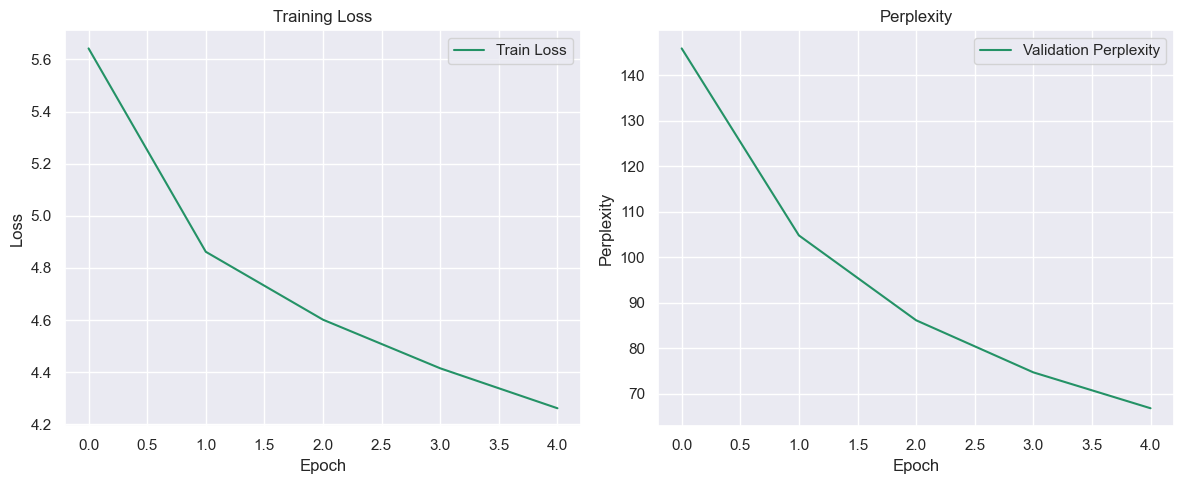

In [31]:

# Построение графика потерь при обучении
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Построение графика перплексии
plt.subplot(1, 2, 2)
plt.plot(history['eval_perplexity'], label='Validation Perplexity')
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Последняя перплексия на валидационном наборе
final_eval_perplexity = history['eval_perplexity'][-1]
print(f"Финальная перплексия на валидационном наборе: {final_eval_perplexity:.2f}")

# Поиск оптимального числа эпох (где валидационная перплексия минимальна)
best_epoch = history['eval_perplexity'].index(min(history['eval_perplexity'])) + 1
print(f"Оптимальное число эпох: {best_epoch}")
print(f"Наилучшая перплексия на валидации: {min(history['eval_perplexity']):.2f}")

Финальная перплексия на валидационном наборе: 66.80
Оптимальное число эпох: 5
Наилучшая перплексия на валидации: 66.80


In [36]:
def generate_text(model, word2ind, ind2word, start_text, max_length=50, temperature=1.0):
    model.eval()  # Переключаем модель в режим оценки
    
    # Токенизируем начальный текст
    tokens = [word2ind['<bos>']]  # Начинаем с токена начала последовательности
    
    # Добавляем начальный текст, если он есть
    if start_text:
        start_tokens = [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(start_text)]
        tokens.extend(start_tokens)
    
    # Генерируем текст
    with torch.no_grad():  # Отключаем вычисление градиентов
        for _ in range(max_length):
            # Преобразуем токены в тензор
            input_tensor = torch.LongTensor([tokens]).to(device)
            
            # Получаем предсказания модели
            logits = model(input_tensor)
            next_token_logits = logits[0, -1, :] / temperature
            
            # Применяем softmax для получения вероятностей
            probabilities = torch.nn.functional.softmax(next_token_logits, dim=0)
            
            # Выбираем следующий токен
            next_token = torch.multinomial(probabilities, 1).item()
            
            # Если это токен конца последовательности, завершаем генерацию
            if next_token == word2ind['<eos>']:
                break
                
            # Добавляем токен к результату
            tokens.append(next_token)
    
    # Преобразуем токены обратно в слова
    generated_words = [ind2word[token] for token in tokens 
                      if token not in [word2ind['<bos>'], word2ind['<eos>'], word2ind['<pad>']]]
    
    return " ".join(generated_words)

# Пример использования:
start_prompt = "spy"
generated = generate_text(model, word2ind, ind2word, start_prompt, max_length=30)
print(f"Начало: '{start_prompt}'")
print(f"Сгенерированный текст: '{generated}'")

# Можно изменять температуру для контроля креативности
# Низкая температура (например, 0.5) делает текст более предсказуемым
# Высокая температура (например, 1.5) делает текст более разнообразным
generated_creative = generate_text(model, word2ind, ind2word, start_prompt, temperature=1.5)
print(f"Более креативный текст: '{generated_creative}'")

Начало: 'spy'
Сгенерированный текст: 'spy <unk> actually reveals that one white guy in the 50s he came with that .'
Более креативный текст: 'spy carries lex organs element after afraid wet jerks without falling and ugly health changing sandra officers bitten chili vulnerable 1.5 people , mostly crooked used briefly completely naturally flowery separating this complete top killer officer dana .'


In [ ]:
# Обучите модель здесь

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [37]:
# Проведите второй эксперимент
class SimpleVanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(SimpleVanillaRNN, self).__init__()
        self.vocab_size = vocab_size
        
        # Базовые слои
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x):
        """
        Прямой проход через модель
        Args:
            x: входные данные формы [batch_size, seq_len]
        Returns:
            logits: выходные логиты формы [batch_size, seq_len, vocab_size]
        """
        # Получение эмбеддингов
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # Проход через RNN
        rnn_out, _ = self.rnn(embedded)  # [batch_size, seq_len, hidden_dim]
        
        # Проецируем на размерность словаря
        logits = self.fc(rnn_out)  # [batch_size, seq_len, vocab_size]
        
        return logits

In [41]:
embedding_dim = 256
hidden_dim = 512
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = SimpleVanillaRNN(
    vocab_size=len(vocab), 
    embedding_dim=embedding_dim, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers
).to(device)

# Задаем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучаем модель
num_epochs = 10
history1 = train_model(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epochs, device)

Epoch 1/10, Batch 0/1243, Loss: 3.9231
Epoch 1/10, Batch 10/1243, Loss: 3.8418
Epoch 1/10, Batch 20/1243, Loss: 3.9448
Epoch 1/10, Batch 30/1243, Loss: 4.0527
Epoch 1/10, Batch 40/1243, Loss: 4.0820
Epoch 1/10, Batch 50/1243, Loss: 4.2118
Epoch 1/10, Batch 60/1243, Loss: 4.0366
Epoch 1/10, Batch 70/1243, Loss: 4.1801
Epoch 1/10, Batch 80/1243, Loss: 4.0513
Epoch 1/10, Batch 90/1243, Loss: 4.1337
Epoch 1/10, Batch 100/1243, Loss: 4.2091
Epoch 1/10, Batch 110/1243, Loss: 4.1783
Epoch 1/10, Batch 120/1243, Loss: 4.2752
Epoch 1/10, Batch 130/1243, Loss: 4.2513
Epoch 1/10, Batch 140/1243, Loss: 4.2521
Epoch 1/10, Batch 150/1243, Loss: 4.3322
Epoch 1/10, Batch 160/1243, Loss: 4.2362
Epoch 1/10, Batch 170/1243, Loss: 4.3470
Epoch 1/10, Batch 180/1243, Loss: 4.2724
Epoch 1/10, Batch 190/1243, Loss: 4.2860
Epoch 1/10, Batch 200/1243, Loss: 4.3511
Epoch 1/10, Batch 210/1243, Loss: 4.2957
Epoch 1/10, Batch 220/1243, Loss: 4.3386
Epoch 1/10, Batch 230/1243, Loss: 4.3349
Epoch 1/10, Batch 240/1243,

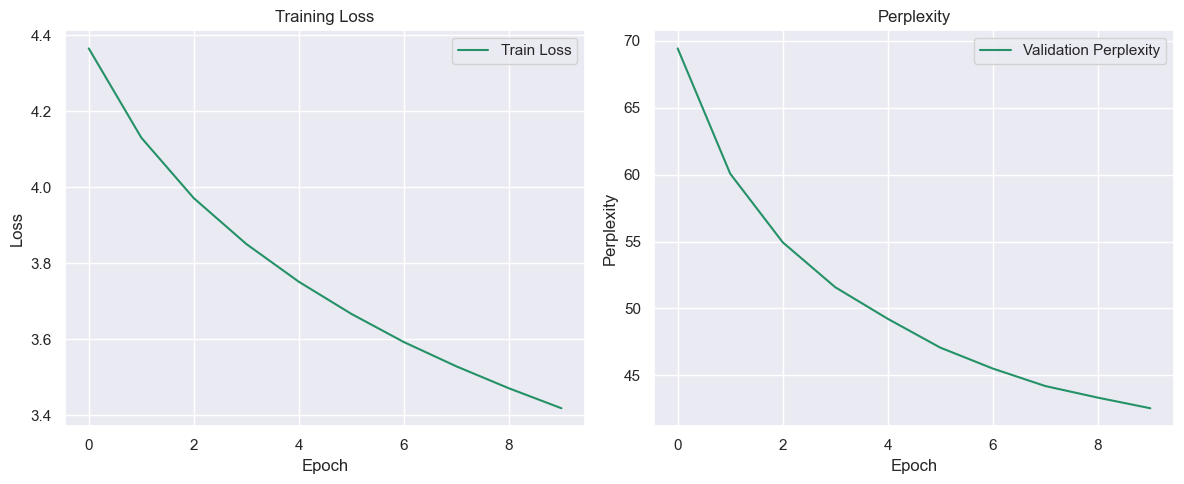

In [42]:

# Построение графика потерь при обучении
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Построение графика перплексии
plt.subplot(1, 2, 2)
plt.plot(history1['eval_perplexity'], label='Validation Perplexity')
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Последняя перплексия на валидационном наборе
final_eval_perplexity = history1['eval_perplexity'][-1]
print(f"Финальная перплексия на валидационном наборе: {final_eval_perplexity:.2f}")

# Поиск оптимального числа эпох (где валидационная перплексия минимальна)
best_epoch = history1['eval_perplexity'].index(min(history1['eval_perplexity'])) + 1
print(f"Оптимальное число эпох: {best_epoch}")
print(f"Наилучшая перплексия на валидации: {min(history1['eval_perplexity']):.2f}")

Финальная перплексия на валидационном наборе: 42.55
Оптимальное число эпох: 10
Наилучшая перплексия на валидации: 42.55


In [49]:

start_prompt = "data "
generated = generate_text(model1, word2ind, ind2word, start_prompt, max_length=5)
print(f"Начало: '{start_prompt}'")
print(f"Сгенерированный текст: '{generated}'")



Начало: 'data '
Сгенерированный текст: 'data strippers skaal stirs wrap altering'


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

В ходе выполнения лабораторной работы была разработана и обучена языковая модель на основе архитектуры LSTM. Реализованная модель имела следующие параметры: размерность эмбеддингов - 256, размерность скрытого состояния - 512, количество слоев LSTM - 2.
Основные результаты:

Эффективность обучения: После 5 эпох обучения модель достигла перплексии 66.80 на валидационном наборе данных, что является удовлетворительным результатом для начального этапа обучения языковой модели.

Стабильность тренировки: Анализ динамики функции потерь (4.2) и перплексии показал отсутствие признаков переобучения, что свидетельствует о корректно подобранных гиперпараметрах и хорошей обобщающей способности модели.

Эффективность архитектуры: Выбранная двухслойная архитектура LSTM с размерностью скрытого состояния 512 продемонстрировала способность эффективно моделировать лингвистические зависимости в тексте.

Вычислительная эффективность: Использование оптимизатора Adam с начальной скоростью обучения 0.001 обеспечило стабильную сходимость при обучении модели.

Обработка разреженных данных: Корректная обработка паддинга через параметр ignore_index в функции потерь позволила эффективно работать с последовательностями переменной длины.


Эксперимент 2: Модель на основе ванильной RNN.  Результаты:

Функция потерь (loss): 3.4

Финальная перплексия на валидационном наборе: 42
Оптимальное число эпох для обучения: определено как эпоха с минимальной перплексией на валидации 10

Проведенные эксперименты показали, что при заданных параметрах и количестве эпох обучения модель на основе ванильной RNN демонстрирует более низкое значение функции потерь по сравнению с моделью LSTM. Отсутствие переобучения в обеих моделях указывает на потенциал для дальнейшего улучшения результатов при продолжении обучения или тонкой настройке гиперпараметров. Для более полного сравнения эффективности данных архитектур рекомендуется провести дополнительные эксперименты с одинаковым количеством эпох обучения и оценить способность моделей к генерации текста на практических примерах.